# Feature Extraction from Time Series Data Using a Neural Network

Currently not using pycbc data yet as constructing the model

TODO:
- Generate simple data -> Done
- Add noise -> Done
- Build NN model for parameter estimation
- Training loop -> Done I think
- Testing of trained model
- Update to pycbc noise
- Update Model to do parameter prosterior prediction, look at dingo
- Update to pycbc data
- Data pre-processing
- Finished?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [44]:
# just generating some datasets for the time being
data_samples = 2000
mean = 10
std = 3
no_time_steps = 360

amplitudes = np.random.normal(mean, std, data_samples)

time_steps = np.linspace(0,120,no_time_steps)

signals = np.array([np.sin(time_steps)*a for a in amplitudes])

# adding noise, just gaussian for the time being
noise_mean = 0
noise_std = 0.5
noised_signals = np.array([x + np.random.normal(noise_mean, noise_std, no_time_steps) for x in signals])

# convert to pytorch datasets
X = torch.FloatTensor(noised_signals)
y = torch.FloatTensor(amplitudes)

data = TensorDataset(X,y)

train_data, val_data, test_data = random_split(data, lengths=[0.8,0.1,0.1])

batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)



Text(0.5, 0, 'Amplitudes')

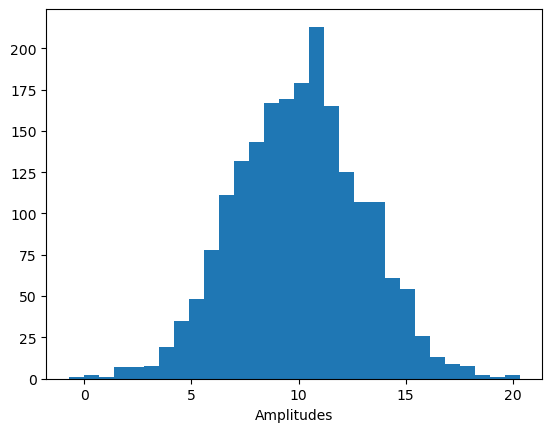

In [45]:
plt.hist(amplitudes, bins=30)
plt.xlabel("Amplitudes")

Text(0, 0.5, 'Amplitude')

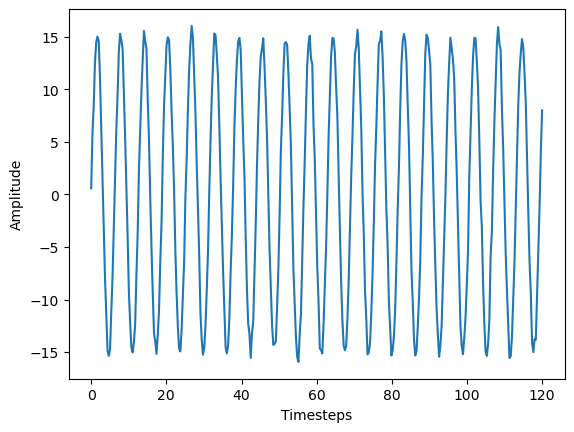

In [46]:
plt.plot(time_steps, noised_signals[0])
plt.xlabel("Timesteps")
plt.ylabel("Amplitude")

## Model

Most suggestions ive seen involve LSTM, probably worth looking into that more

In [39]:
# This initial implimentation is all from claude AI
# Going to try and get this working a bit and understand it
# And will then update

class ParameterPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, 
                           hidden_size=256, 
                           num_layers=1, 
                           batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64,1)
        )
    
    def forward(self, x):
        # Reshape input to [batch, sequence, features]
        x = x.unsqueeze(-1)  # Add feature dimension: [batch, 4000, 1]
        lstm_out, _ = self.lstm(x)
        # Use last output for prediction
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out).squeeze(-1)

# Training Loop
Updated from code I wrote for the DSML Exam

In [40]:
def train_model(model, optimizer, loss_fcn, n_epochs, train_dloader, val_dloader, start_epoch = 0, patience = 3):
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    best_val_loss = float('inf')
    best_val_epoch = 0

    for epoch in range(start_epoch, start_epoch + n_epochs):
        model.train()
        tloss, vloss = 0, 0
        train_predictions = []
        train_targets = []

        for X_train, y_train in tqdm(train_dloader, desc='Epoch {}, training'.format(epoch+1)):
            optimizer.zero_grad()
            pred = model(X_train)
            loss = loss_fcn(pred, y_train.flatten())            
            tloss += loss.item()
            loss.backward()
            optimizer.step()
            
            train_predictions.extend(pred.detach().numpy())
            train_targets.extend(y_train.flatten().numpy())

            
        model.eval()
        vloss = 0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            vtrue_preds, vcount = 0., 0
            for X_valid, y_valid in tqdm(val_dloader, desc='Epoch {}, validation'.format(epoch+1)):
                pred = model(X_valid)
                loss = loss_fcn(pred, y_valid.flatten())
                vloss += loss.item()


                val_predictions.extend(pred.numpy())
                val_targets.extend(y_valid.flatten().numpy())

        # Calculate metrics
        train_metrics_dict = calculate_metrics(
            np.array(train_predictions), 
            np.array(train_targets)
        )
        val_metrics_dict = calculate_metrics(
            np.array(val_predictions), 
            np.array(val_targets)
        )

        # Store losses
        avg_train_loss = tloss / len(train_dloader)
        avg_val_loss = vloss / len(val_dloader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Store metrics
        train_metrics.append(train_metrics_dict)
        val_metrics.append(val_metrics_dict)

        # Print epoch results
        print(f"\n[Epoch {epoch+1:2d}]")
        print(f"Training - Loss: {avg_train_loss:.4f}, MAE: {train_metrics_dict['mae']:.4f}, "
              f"RMSE: {train_metrics_dict['rmse']:.4f}, R²: {train_metrics_dict['r2']:.4f}")
        print(f"Validation - Loss: {avg_val_loss:.4f}, MAE: {val_metrics_dict['mae']:.4f}, "
              f"RMSE: {val_metrics_dict['rmse']:.4f}, R²: {val_metrics_dict['r2']:.4f} \n")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            print("New best validation performance \n")
            best_val_loss = avg_val_loss
            best_val_epoch = epoch
        elif best_val_epoch <= epoch - patience:
            print(f'No improvement in validation loss in last {patience} epochs \n')
            break

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics
    }

def calculate_metrics(predictions, targets):
    """Calculate regression metrics for parameter estimation"""
    mae = np.mean(np.abs(predictions - targets))
    rmse = np.sqrt(np.mean((predictions - targets) ** 2))
    
    # R² score
    ss_res = np.sum((targets - predictions) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

In [47]:
model = ParameterPredictor()
lossfcn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)

outputs = train_model(model, optimizer, lossfcn, 30, train_loader, val_loader)

Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 69.70it/s]



[Epoch  1]
Training - Loss: 13.6933, MAE: 2.6021, RMSE: 3.7004, R²: -0.5186
Validation - Loss: 16.0238, MAE: 3.3774, RMSE: 3.9916, R²: -1.0178 

New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 70.84it/s]



[Epoch  2]
Training - Loss: 6.1704, MAE: 1.8881, RMSE: 2.4840, R²: 0.3157
Validation - Loss: 0.9726, MAE: 0.7674, RMSE: 0.9810, R²: 0.8781 

New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 77.60it/s]



[Epoch  3]
Training - Loss: 0.8528, MAE: 0.7411, RMSE: 0.9235, R²: 0.9054
Validation - Loss: 1.2899, MAE: 0.9881, RMSE: 1.1417, R²: 0.8349 



Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 69.33it/s]



[Epoch  4]
Training - Loss: 0.7059, MAE: 0.6757, RMSE: 0.8402, R²: 0.9217
Validation - Loss: 0.5391, MAE: 0.5948, RMSE: 0.7375, R²: 0.9311 

New best validation performance 



Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 76.67it/s]



[Epoch  5]
Training - Loss: 0.6234, MAE: 0.6377, RMSE: 0.7896, R²: 0.9309
Validation - Loss: 0.5093, MAE: 0.5705, RMSE: 0.7150, R²: 0.9353 

New best validation performance 



Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 70.83it/s]



[Epoch  6]
Training - Loss: 0.8725, MAE: 0.7499, RMSE: 0.9341, R²: 0.9032
Validation - Loss: 0.8574, MAE: 0.7953, RMSE: 0.9315, R²: 0.8901 



Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 74.03it/s]



[Epoch  7]
Training - Loss: 0.5576, MAE: 0.5973, RMSE: 0.7467, R²: 0.9382
Validation - Loss: 0.3891, MAE: 0.5011, RMSE: 0.6265, R²: 0.9503 

New best validation performance 



Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 74.91it/s]



[Epoch  8]
Training - Loss: 0.4650, MAE: 0.5449, RMSE: 0.6819, R²: 0.9484
Validation - Loss: 0.3622, MAE: 0.4892, RMSE: 0.6066, R²: 0.9534 

New best validation performance 



Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 70.84it/s]



[Epoch  9]
Training - Loss: 0.3639, MAE: 0.4790, RMSE: 0.6033, R²: 0.9596
Validation - Loss: 0.2792, MAE: 0.4188, RMSE: 0.5315, R²: 0.9642 

New best validation performance 



Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 70.08it/s]



[Epoch 10]
Training - Loss: 0.3232, MAE: 0.4540, RMSE: 0.5685, R²: 0.9642
Validation - Loss: 0.2424, MAE: 0.3888, RMSE: 0.4952, R²: 0.9689 

New best validation performance 



Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 72.02it/s]



[Epoch 11]
Training - Loss: 0.2586, MAE: 0.4044, RMSE: 0.5085, R²: 0.9713
Validation - Loss: 0.1989, MAE: 0.3557, RMSE: 0.4508, R²: 0.9743 

New best validation performance 



Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 69.65it/s]



[Epoch 12]
Training - Loss: 0.2278, MAE: 0.3759, RMSE: 0.4773, R²: 0.9747
Validation - Loss: 0.1929, MAE: 0.3551, RMSE: 0.4429, R²: 0.9752 

New best validation performance 



Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 69.33it/s]



[Epoch 13]
Training - Loss: 0.2115, MAE: 0.3648, RMSE: 0.4599, R²: 0.9765
Validation - Loss: 0.2125, MAE: 0.3623, RMSE: 0.4622, R²: 0.9729 



Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 66.17it/s]



[Epoch 14]
Training - Loss: 0.1930, MAE: 0.3445, RMSE: 0.4393, R²: 0.9786
Validation - Loss: 0.1354, MAE: 0.2880, RMSE: 0.3706, R²: 0.9826 

New best validation performance 



Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 68.60it/s]



[Epoch 15]
Training - Loss: 0.1431, MAE: 0.2980, RMSE: 0.3783, R²: 0.9841
Validation - Loss: 0.1112, MAE: 0.2702, RMSE: 0.3363, R²: 0.9857 

New best validation performance 



Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 69.70it/s]



[Epoch 16]
Training - Loss: 0.1428, MAE: 0.2972, RMSE: 0.3779, R²: 0.9842
Validation - Loss: 0.1185, MAE: 0.2679, RMSE: 0.3448, R²: 0.9849 



Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 71.54it/s]



[Epoch 17]
Training - Loss: 0.1443, MAE: 0.2983, RMSE: 0.3799, R²: 0.9840
Validation - Loss: 0.0986, MAE: 0.2542, RMSE: 0.3152, R²: 0.9874 

New best validation performance 



Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 68.95it/s]



[Epoch 18]
Training - Loss: 0.1164, MAE: 0.2643, RMSE: 0.3412, R²: 0.9871
Validation - Loss: 0.0803, MAE: 0.2297, RMSE: 0.2856, R²: 0.9897 

New best validation performance 



Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 72.02it/s]



[Epoch 19]
Training - Loss: 0.1116, MAE: 0.2604, RMSE: 0.3341, R²: 0.9876
Validation - Loss: 0.1558, MAE: 0.3332, RMSE: 0.3958, R²: 0.9802 



Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]



[Epoch 20]
Training - Loss: 0.0954, MAE: 0.2437, RMSE: 0.3089, R²: 0.9894
Validation - Loss: 0.0768, MAE: 0.2231, RMSE: 0.2797, R²: 0.9901 

New best validation performance 



Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 69.70it/s]



[Epoch 21]
Training - Loss: 0.0976, MAE: 0.2467, RMSE: 0.3124, R²: 0.9892
Validation - Loss: 0.0767, MAE: 0.2247, RMSE: 0.2787, R²: 0.9902 

New best validation performance 



Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 68.24it/s]



[Epoch 22]
Training - Loss: 0.1092, MAE: 0.2629, RMSE: 0.3305, R²: 0.9879
Validation - Loss: 0.0765, MAE: 0.2211, RMSE: 0.2790, R²: 0.9901 

New best validation performance 



Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 65.98it/s]



[Epoch 23]
Training - Loss: 0.0850, MAE: 0.2289, RMSE: 0.2915, R²: 0.9906
Validation - Loss: 0.0939, MAE: 0.2531, RMSE: 0.3081, R²: 0.9880 



Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 72.82it/s]



[Epoch 24]
Training - Loss: 0.1105, MAE: 0.2660, RMSE: 0.3324, R²: 0.9877
Validation - Loss: 0.1409, MAE: 0.3131, RMSE: 0.3765, R²: 0.9821 



Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]


[Epoch 25]
Training - Loss: 0.1066, MAE: 0.2595, RMSE: 0.3265, R²: 0.9882
Validation - Loss: 0.0864, MAE: 0.2430, RMSE: 0.2966, R²: 0.9889 

No improvement in validation loss in last 3 epochs 



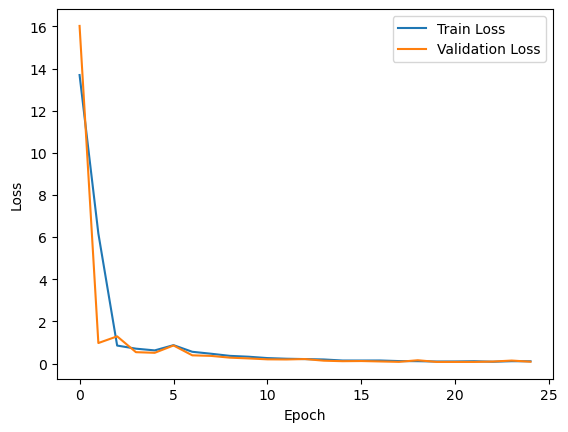

In [48]:
plt.plot(outputs['train_losses'], label='Train Loss')
plt.plot(outputs['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluation

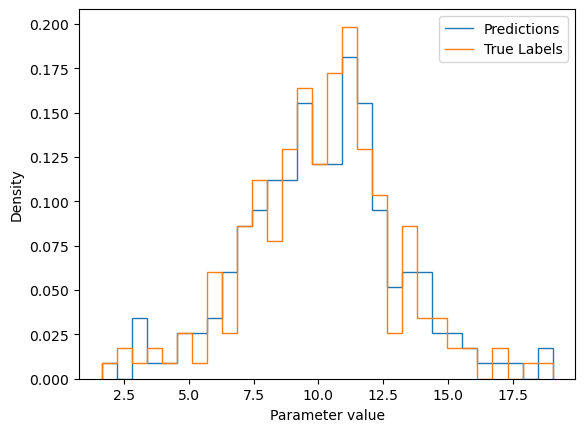

Test RMSE: 0.2699 ± 0.0474


In [49]:
predictions = []
labels = []
rmse_list = []

for X_test, y_test in test_loader:
    test_predictions = model(X_test).detach().numpy()
    test_targets = y_test.numpy()
    predictions.extend(test_predictions)
    labels.extend(test_targets)
    rmse = np.sqrt(np.mean((test_predictions - test_targets) ** 2))
    rmse_list.append(rmse)

plt.figure()
l_counts, l_edges = np.histogram(labels, bins=30, density=True)
p_counts, p_edges = np.histogram(predictions, bins=l_edges, density=True)# align bins with predictions
plt.stairs(p_counts, p_edges, label='Predictions', color='C0')
plt.stairs(l_counts, l_edges, label='True Labels', color='C1')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f'Test RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}')

random pycbc stuff

In [ ]:
from pycbc.waveform import get_td_waveform

hp, hc = get_td_waveform(approximant="IMRPhenomD", mass1=10,mass2=10,spin1z=0.9,delta_t=1/4096,f_lower=40)

print(hp.sample_times)

Explanation by copilot, I am using too much ai :(

    LSTM — short summary

LSTM (Long Short‑Term Memory) is a recurrent neural unit designed to learn long‑range dependencies in sequences.
Core components: cell state (long‑term memory) and three gates — input (what to write), forget (what to drop), output (what to expose).
Gates are learned multiplicative filters (sigmoid activations) that control information flow, which prevents vanishing/exploding gradients for long sequences.
How the notebook uses an LSTM (concise mapping to your code)

Input shape: X comes in as [batch, seq_len] and the model does x = x.unsqueeze(-1) → [batch, seq_len, 1] so feature_dim=1 per timestep.
LSTM instantiation: nn.LSTM(input_size=1, hidden_size=..., num_layers=...) — this processes the time series and produces outputs at every timestep plus hidden/cell states.
last_out = lstm_out[:, -1, :] — the code takes the last timestep's LSTM output (a fixed-length vector summarising the sequence) and feeds it to a small fully connected head that outputs a single scalar parameter.
Training target: regression (MSE) to the scalar parameter (amplitude).
Is an LSTM the best approach for pulling out a single parameter?
Short answer: not necessarily — it depends on the problem, noise, waveform knowledge, and compute/data budget.

When LSTM is appropriate

Temporal ordering matters and the parameter depends on long‑range time relationships in a way that simple summary stats can't capture.
You have enough labelled training examples to learn those dependencies.
You want a learned, flexible sequence encoder that can handle variable‑length inputs (with care).
When something else is often better

If the goal is to extract a single global parameter (e.g., amplitude, phase, frequency) from a known deterministic signal in noise, classical signal processing or matched filtering is usually superior (optimal in Gaussian noise, efficient, and interpretable).
If you only need a robust scalar estimate and not to reproduce or model the waveform, much simpler/faster options work well:
Summary statistics (mean, variance), peaks in Fourier/periodogram, envelope detection.
Matched filtering / template fitting (especially for gravitational‑wave style waveforms).
1D CNN + global pooling (faster to train than LSTM, good at local patterns and translational invariance).
Linear / kernel regression on engineered features (FFT magnitudes, wavelet coefficients).
If you want uncertainty or a posterior

LSTM + deterministic head gives point estimates only. For uncertainties / posteriors:
Predict mean and log‑variance and train with Gaussian NLL loss.
Use MC dropout or deep ensembles for approximate uncertainty.
Use probabilistic models / normalizing flows / amortized inference for full posterior estimates (dingo, conditional density estimators).
Practical improvements you can make if you keep LSTM

Normalize input sequences (zero mean, unit variance per sample or dataset).
Downsample or window the sequence to shorten seq_len if signal is smooth.
Use global pooling over timesteps (mean/max) or attention over timesteps instead of only last timestep.
Consider a 1D CNN encoder (fewer parameters, faster) or hybrid CNN→LSTM (CNN extracts local features, LSTM aggregates).
Predict both value and uncertainty (e.g., output mu and log_sigma and train with negative log likelihood).
Recommendation (concise)

If you know the waveform shape and noise approximates Gaussian: use matched filtering or template fitting — best accuracy and interpretability.
If you want a learned estimator and have lots of labelled data: 1D CNN with global pooling or a small encoder + MLP (or CNN+attention) is usually faster and as effective as an LSTM for extracting a single scalar.
If you need uncertainties/posteriors, augment the model to predict variance or use probabilistic/ensemble methods.
If you want, I can:

Show a compact 1D‑CNN regressor example that maps sequence → scalar (faster than LSTM), or
Add uncertainty prediction to your LSTM head (mu, sigma) with Gaussian NLL loss.